<a href="https://colab.research.google.com/github/ssbracey/practical-nlp-code/blob/master/Introduction_to_Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Python

Natural language processing - commonly referred to as NLP - is the area of computer science dedicated to computers understanding human language such as speech or text. There are many examples of NLP applications including the following:

- Sentiment Analysis - Determine the tone of text
- Speech Recognition - Translate a sound clip to text
- Predictive Text - Complete sentences based on a few words

In this course, we will walk through the basics of NLP with Python libraries such as pandas, spaCy, and scikit-learn. We will cover the following topics:
- Preprocessing
- Token Frequency
- Part of Speech Tagging
- Named Entity Recognition
- Text Similarity
- Dependency Parsing

This course assumes you have a beginner to intermediate knowledge of Python.

In [1]:
# Upgrade nltk library for jaro winkler similarity later in the course
# Must restart your runtime afterwards
!pip install nltk==3.4.5

     |████████████████████████████████| 1.5 MB 5.8 MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449923 sha256=db46b6152046721d6255ef0165eb6510535bb498924f28c25c2cbac689cf82da
  Stored in directory: /root/.cache/pip/wheels/48/8b/7f/473521e0c731c6566d631b281f323842bbda9bd819eb9a3ead
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


## spaCy
Throughout this tutorial, we will be using a spaCy, a popular open-source library for NLP in Python. The library is designed to help you create applications that process and understand text. spaCy offers several pre-made text processing pipelines on their site. The pipelines are packaged as [models](https://spacy.io/models/en) which can be downloaded. For this demo, we will download the small English model trained on text from blogs, news, and comments.

In [2]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 5.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
import pandas as pd
import spacy
from spacy import displacy
import string
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path
from yellowbrick.text import FreqDistVisualizer
import warnings

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 200
nlp = spacy.load('en_core_web_sm')

## The Data
In this course, we will analyze a sample of 500 Amazon Home and Kitchen product reviews. [The data](http://jmcauley.ucsd.edu/data/amazon/links.html) is provided by Julian McAuley at the University of California, San Diego and contains reviews from May 1996 - July 2014. In addition to reviews (ratings, text, helpfulness votes), McAuley provides product metadata (descriptions, category information, price, brand, and image features) and links (also viewed/also bought graphs). 

For this course, we will focus on the review data only. This data is a great example of the ways humans typically communicate through text and includes reviews with typos, run on sentences, and grammatical errors.

McAuley provides the following functions to parse the JSON dataset and save it as a dataframe.

In [4]:
def parse(path):
    f = open(path, 'rb')
    for l in f:
        yield eval(l)


def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

To get the data, follow [this link](https://shorturl.at/wIY27) select the dropdown next to "PyCon" and select "Add shortcut to drive"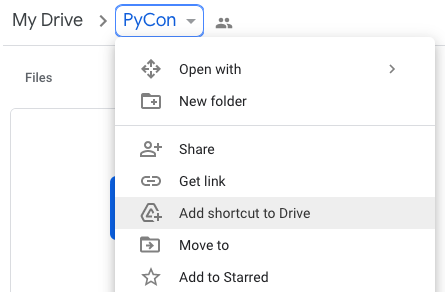

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = getDF('/content/drive/MyDrive/PyCon/reviews_Home_and_Kitchen_5.json')
df_sample = df.sample(n=500, random_state=1)

In [7]:
df_sample.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
338364,A3SU2IZMOTDPGI,B002YK4ESI,irishyank,"[1, 5]",I opened the box and to my surprise the scoop ...,1.0,Failed me,1294876800,"01 13, 2011"
267506,A1TRKTTP1NM71H,B001FB6IFY,"Dr. Dave ""-- Fair and Balanced Reviews""","[1, 6]",I purchased this thermometer because a friend ...,5.0,Great Thermometer - Disappointing Weekend,1358985600,"01 24, 2013"
428410,A2A4C5N5B47Z0Q,B0051AQXZK,Paula Philbrick,"[0, 0]","The mattress was custom for my daughter, and s...",5.0,Hard to Get Out of Bed,1375660800,"08 5, 2013"
262480,ANVISS3NQQBFD,B001E5CWVU,A. J. Marshall,"[3, 3]","This is entirely my own fault, but hopefully p...",4.0,Too small for a lot of recipes,1372118400,"06 25, 2013"
241188,A2LQ1O3IHJQPFF,B00179D7IK,Meredith,"[0, 0]","My long-time teapot recently broke, so I decid...",4.0,Cute teapot,1368057600,"05 9, 2013"


## Text Preprocessing
Text preprocessing applies a variety of steps to text in order to clean or transform it for the computer to better understand. There are several common preprocessing steps. Let's take an example sentence and apply these steps to it.

Sentence: "She was offered the job 11 months ago."

- Lowercase 
    - "she was offered the job 11 months ago."
- Remove punctuation 
    - "she was offered the job 11 months ago"
- Remove numbers 
    - "she was offered the job months ago"
- Remove stop words - remove words that are very common in the English language 
    - "she offered job months ago"
- Tokenization - splitting the sentence up into tokens 
    - "she", "offered", "job", "months", "ago"
- Stemming / lemmatization - transforming the token into its root form 
    - "offer", "job", "month", "ago"

While these are all very popular preprocessing steps, they may not all be used on every project or even in this same order. The data you have and the problem you're trying to solve may add or remove any of these steps (and more) from your preprocessing. For example, if you want to see how many sentences are in the average Amazon review, you shouldn't remove punctuation.

spaCy allows us to apply all of the preprocessing steps above in a single line of code by using [token attributes](https://spacy.io/api/token#attributes).
- `token.lemma_` - lemmatizes the token
- `token.is_alpha` - Removes punctuation and numbers (non-alphabetic characters)
- `token.is_stop` - Removes stop words

In [ ]:
# Try out text preprocessing on sample text
text = "She was offered the job 11 months ago."
doc = nlp(text)
text_clean = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]

In [ ]:
print(doc)

In [ ]:
print(text_clean)

In [ ]:
# Preprocess the entire dataframe
def preprocess_text(spacy_doc: spacy.tokens.doc.Doc) -> str:
    """
    Preprocess a spacy Doc by lemmatizing, removing stop words, and removing non-alphabetical characters.
    
    Parameters
    ----------
    spacy_doc: spacy.tokens.doc.Doc
        A spacy Doc object, i.e. a sequence of Token objects

    Returns
    -------
    str
        The cleaned text

    """
    text_clean = [token.lemma_.lower() for token in spacy_doc if token.is_alpha and not token.is_stop]
    return ' '.join(text_clean)


df_sample['spacy_doc'] = df_sample['reviewText'].apply(lambda x: nlp(x))
df_sample['review_text_clean'] = df_sample['spacy_doc'].apply(lambda x: preprocess_text(x))

In [ ]:
print(df_sample['spacy_doc'].head())

In [ ]:
print(df_sample['review_text_clean'].head())

## Term Frequency
With thousands of data points, we don't have time to read through each individual review to learn more about the data set. One way we can summarize the data is through the most popular words in reviews (term frequency). To do this, we use `CountVectorizer` from `scikit-learn`.

CountVectorizer converts text into a matrix of token counts. It has a variety of [parameters](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) you can use to customize your results, but we will focus on `stop_words` and `ngram_range`.

Although we previously removed stop words in our preprocessing steps, scikit-learn uses a different set of stop words than spaCy. Oftentimes it is beneficial to combine multiple stop words lists or create your own custom list to exclude common words that don't add value.

N-grams are used to break text up into chunks. An example of a 1-gram is "hello", and an example of a 2-gram is "hello there". Modifying the `ngram_range` in `CountVectorizer` allows us to see the most popular words AND most popular phrases.

### CountVectorizer

In [ ]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))
docs = vectorizer.fit_transform(df_sample['review_text_clean'])
features = vectorizer.get_feature_names()

Next, we plot the most popular words with `FreqDistVisualizer` from `scikit-yellowbrick`.

In [ ]:
visualizer = FreqDistVisualizer(features=features, size=(1080, 700))
visualizer.fit(docs)
visualizer.show()

### Compare Top Tokens for Helpful/Unhelpful Reviews

We work on a lot of multi-class classification problems in our day jobs, and one thing we like to do when exploring the data is see how the most frequent tokens in each class compare to each other. Ideally, each class will have distinct tokens, which makes it easier for our model to predict which class the text belongs to.

For this example, let's assume we want to create a classifier to predict whether or not a review will be helpful. We'll split our data into two classes: "helpful" and "not helpful". We'll consider a review to be "helpful" if at least 50% of people who rated the review found it helpful. To calculate this, we'll look at the "helpful" column in our data set.

In [ ]:
def calculate_helpful_percent(x: list) -> float:
  """
    Calculates the percent of people who found a review helpful based on the
    "helpful" column in our dataframe. The "helpful" column is formatted as
    [1, 3] for example. This means that 1 out of 3 people found the review
    helpful. We calculate the percent by taking the first number divided by 
    the second number.
    
    Parameters
    ----------
    x: list
        A list of two integers. The first number is the number of people
        who found the review helpful. The second number is the total number
        of people who rated the review.

    Returns
    -------
    float
      The percent of people who found the review helpful

  """
  if x[1] != 0:
    return x[0] / x[1]
  else:
    return 0

df_sample['helpful_percent'] = df_sample['helpful'].apply(lambda x: calculate_helpful_percent(x))
df_sample['classification'] = df_sample['helpful_percent'].apply(lambda x: 'helpful' if x >= 0.5 else 'not helpful')

In [ ]:
df_sample.head()

In [ ]:
df_sample['classification'].value_counts()

Let's look at the most frequent tokens in helpful reviews

In [ ]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))
docs = vectorizer.fit_transform(df_sample.loc[df_sample['classification'] == 'helpful', 'review_text_clean'])
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, size=(1080, 720))
visualizer.fit(docs)
visualizer.show()

Let's see how these tokens compare to not helpful reviews

In [ ]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))
docs = vectorizer.fit_transform(df_sample.loc[df_sample['classification'] == 'not helpful', 'review_text_clean'])
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, size=(1080, 720))
visualizer.fit(docs)
visualizer.show()

### Analyze Token Counts

While exploring our data, we should probably see how long our reviews are (i.e. how many tokens are in a review). We can see how the original text and the preprocessed text compare.

In [ ]:
df_sample['token_count_all'] = df_sample['spacy_doc'].apply(lambda x: len(x))
df_sample['token_count_clean'] = df_sample['review_text_clean'].apply(lambda x: len(x.split()))

In [ ]:
df_sample.head()

In [ ]:
df_sample['token_count_all'].value_counts().sort_index().plot.bar(figsize=(40,5), 
                                                                    title='All Tokens per Review',
                                                                    xlabel='Tokens',
                                                                    ylabel='Number of Reviews')

In [ ]:
df_sample['token_count_clean'].value_counts().sort_index().plot.bar(figsize=(17,5), 
                                                                    title='Clean Tokens per Review',
                                                                    xlabel='Tokens',
                                                                    ylabel='Number of Reviews')

In [ ]:
df_sample[df_sample['token_count_clean'] == 271]['reviewText'].values[0]

## Named Entity Recognition
Named Entity Recognition (NER) identifies real-world objects such as people, places, or things in text. NER is useful in many scenarios such as identifying and masking sensitive information such as names of people. spaCy recognizes [several different types of entities](https://v2.spacy.io/api/annotation#named-entities) and has a nice visualization to highlight all entities it recognized in text. 

In [ ]:
doc = df_sample['spacy_doc'][271416]
print(doc)
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
displacy.render(df_sample['spacy_doc'][271416], style="ent", jupyter=True)

In [ ]:
# Recognize all entities in all Amazon reviews
df_entities = pd.DataFrame(columns=['index', 'spacy_doc', 'entity_text', 'entity_label', 'entity_start', 'entity_end'])

index = 0
for row in df_sample.itertuples():
    for ent in row.spacy_doc.ents:
        df_entities.at[index, 'index'] = row.Index
        df_entities.at[index, 'spacy_doc'] = row.spacy_doc
        df_entities.at[index, 'entity_text'] = ent.text
        df_entities.at[index, 'entity_label'] = ent.label_
        df_entities.at[index, 'entity_start'] = ent.start_char
        df_entities.at[index, 'entity_end'] = ent.end_char
        index += 1

In [ ]:
df_entities.head()

In [ ]:
#See the most popular entities recognized
df_entities['entity_label'].value_counts()

In [ ]:
#See what products are recognized
df_filtered = df_entities[df_entities['entity_label'] == 'ORG']

In [ ]:
df_filtered['entity_text'].value_counts()

## Part of Speech Tagging
Part-of-Speech tagging determines which [part of speech](https://en.wikipedia.org/wiki/Part_of_speech) each token is. This usually occurs behind the scenes before lemmatization since many words can serve as multiple parts of speech and may be lemmatized differently depending on the certain part of speech. Additionally, POS tagging is used as a foundation for NER and many other text processing steps. One real world application of POS tagging is to distinguish between words with the same spelling but different meanings for translation. For example, if a computer was translating "Can you throw this can in the trash?" to Spanish, it would need to know that "can" has two different parts of speech in this sentence.

In [ ]:
doc = df_sample['spacy_doc'][271416]
for token in doc:
    print(token.text, token.pos_, token.dep_)

### Dependency Parsing

In [ ]:
# Dependency Parsing

displacy.render(df_sample['spacy_doc'][271416], style="dep", jupyter=True)

### Count Adjectives and Adverbs

In [ ]:
for token in doc:
    if token.pos_ == 'ADJ' or token.pos_ == 'ADV':
        print(token.text, token.pos_, token.dep_)

In [ ]:
def count_adverbs_adjectives(spacy_doc: spacy.tokens.doc.Doc) -> int:
    """
    Count the number of adjectives and adverbs in the text
    
    Parameters
    ----------
    spacy_doc: spacy.tokens.doc.Doc
        A spacy Doc object, i.e. a sequence of Token objects

    Returns
    -------
    int
        The number of adverbs and adjectives in the text

    """
    counter = 0
    for token in spacy_doc:
        if token.pos_ == 'ADJ' or token.pos_ == 'ADV':
            counter+=1
    
    return counter   

In [ ]:
df_sample['count_adj_adv'] = df_sample['spacy_doc'].apply(lambda x: count_adverbs_adjectives(x))

In [ ]:
df_sample['count_adj_adv'].value_counts().sort_index().plot.bar(figsize=(15,5))

In [ ]:
df_sample[df_sample['count_adj_adv'] == 124]['reviewText'].values[0]

##Text Similarity
Text similarity determines how similar two documents are. We can determine similarity in two broad categories: lexical and semantic. Lexical similarity allows us to consider documents to be similar based on the literal words that are shared between documents. In other words, the more words two documents have in common, the more similar the documents are. Semantic similarity takes into account the meaning of the documents. For example, if one document talks about cars while another document talks about buses, those two documents may have a high semantic similarity.

For this course, we will mainly focus on lexical similarity, specifically Jaccard and Cosine similarity, as well as edit distance. Popular semantic similarity methods include [Word2Vec](https://jalammar.github.io/illustrated-word2vec/) and [BERT](https://huggingface.co/blog/bert-101).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from nltk import jaccard_distance
# Note - nltk calls Levenshtein distance "edit_distance"
from nltk.metrics.distance import edit_distance, jaro_winkler_similarity

### Levenshtein Edit Distance

In [ ]:
def calculate_levenshtein_edit_distance_matrix(corpus_list: list) -> np.ndarray:
  """
  Create a matrix of Levenshtein edit distance for all documents in our corpus.
  This is the number of edits it takes to transform one document into another.
  Two documents are considered identical if they have a Levenshtein edit 
  distance of 0, so the diagonal of our matrix will be all 0's.

  Parameters
  ----------
  corpus_list: list
      The corpus formatted as a list

  Returns
  -------
  edit_distance_matrix: np.ndarray
    A matrix containing the number of edits to get from one string to another for
    all items in the corpus

  """
  col_len = len(corpus_list)
  edit_distance_list = []
  for str_a in corpus_list:
    for str_b in corpus_list:
      edit_distance_list.append(edit_distance(str_a, str_b))

  levenshtein_edit_distance_matrix = np.array(edit_distance_list).reshape(col_len, col_len)
  
  return levenshtein_edit_distance_matrix

In [ ]:
# Define our corpus
corpus = df_sample['review_text_clean'][:10]

# Calculate our jaccard similarity matrix
corpus_list = list(corpus)
levenshtein_edit_distance_matrix = calculate_levenshtein_edit_distance_matrix(corpus_list)

In [ ]:
levenshtein_edit_distance_matrix

In [ ]:
# Compare two reviews to each other
review_1_idx = 2 # this review is about a mattress
review_2_idx = 3 # this review is about a crockpot

print(corpus_list[review_1_idx])
print(corpus_list[review_2_idx])
print(levenshtein_edit_distance_matrix[review_1_idx, review_2_idx])

### Jaro-Winkler Similarity

In [ ]:
def calculate_jaro_winkler_matrix(corpus_list: list) -> np.ndarray:
  """
  Create a Jaro Winkler similarity matrix for all documents in our corpus.
  This is the number of edits it takes (including transpositions) to transform 
  one document into another. Two documents are considered identical if they
  have a Jaro-Winkler similarity of 1, so the diagonal of our matrix will be 
  all 1's.

  Parameters
  ----------
  corpus_list: list
      The corpus formatted as a list

  Returns
  -------
  jaro_winkler_matrix: np.ndarray
    A matrix containing jaro winkler similarity scores for all items in the corpus

  """
  col_len = len(corpus_list)
  jaro_winkler_list = []
  for str_a in corpus_list:
    for str_b in corpus_list:
      jaro_winkler_list.append(jaro_winkler_similarity(str_a, str_b))

  jaro_winkler_matrix = np.array(jaro_winkler_list).reshape(col_len, col_len)
  
  return jaro_winkler_matrix

In [ ]:
# Define our corpus
corpus = df_sample['review_text_clean'][:10]

# Calculate our jaro winkler similarity matrix
corpus_list = list(corpus)
jaro_winkler_matrix = calculate_jaro_winkler_matrix(corpus_list)

In [ ]:
# Print via for loop so we can see the diagonal easily
for row in jaro_winkler_matrix:
  for item in row:
    print('%3f ' % item, end="")
  print()

In [ ]:
# Compare two reviews to each other
review_1_idx = 2
review_2_idx = 3

print(corpus_list[review_1_idx])
print(corpus_list[review_2_idx])
print(jaro_winkler_matrix[review_1_idx, review_2_idx])

### Jaccard Similarity

In [ ]:
def calculate_jaccard_similarity_matrix(corpus_list: list) -> np.ndarray:
  """
  Create a jaccard similarity matrix for all documents in our corpus.
  This is the intersection of unique tokens in the document divided by the
  union of unique words in both documents. Two documents are considered 
  identical if they have a Jaccard similarity score of 1, so the diagonal
  of our matrix will be all 1's.

  Parameters
  ----------
  corpus_list: list
      The corpus formatted as a list

  Returns
  -------
  jaccard_matrix: np.ndarray
    A matrix containing jaccard similarity scores for all items in the corpus

  """
  col_len = len(corpus_list)
  jaccard_list = []
  for str_a in corpus_list:
    set_a = set(str_a.split())
    for str_b in corpus_list:
      set_b = set(str_b.split())
      jaccard_list.append(1 - jaccard_distance(set_a, set_b))

  jaccard_matrix = np.array(jaccard_list).reshape(col_len, col_len)
  
  return jaccard_matrix

In [ ]:
# Define our corpus
corpus = df_sample['review_text_clean']

# Calculate our jaccard similarity matrix
corpus_list = list(corpus)
jaccard_matrix = calculate_jaccard_similarity_matrix(corpus_list)

In [ ]:
# Compare two reviews to each other
review_1_idx = 2
review_2_idx = 3

print(corpus_list[review_1_idx])
print(corpus_list[review_2_idx])
print(jaccard_matrix[review_1_idx, review_2_idx])

### Cosine Similarity with TFIDF

In [ ]:
# TF-IDF Feature Extraction 
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(corpus, (1,1))

# Calculate our cosine similary matrix
cosine_similarity_matrix = cosine_similarity(tf_idf)

In [ ]:
print(corpus_list[review_1_idx])
print(corpus_list[review_2_idx])
print(cosine_similarity_matrix[review_1_idx, review_2_idx])

### Get the most similar reviews via each method

Get the most similar reviews using Levenshtein edit distance. Remember, we only calculated the Levenshtein edit distance for the first 10 reviews. 

In [ ]:
# get the indices for the min where not 0
indices = np.argwhere(levenshtein_edit_distance_matrix == np.min(levenshtein_edit_distance_matrix[np.nonzero(levenshtein_edit_distance_matrix)]))

# Print the max similarity for our data set
print(f"Minimum Levenshtein distance: {levenshtein_edit_distance_matrix[indices[0][0], indices[1][0]]}")

# Print the review text
print(corpus_list[indices[0][0]])
print(corpus_list[indices[1][0]])

Get the most similar reviews using Jaro Winkler similarity. Remember, we only calculated the Jaro Winkler similarity for the first 10 reviews.

In [ ]:
# fill the values along the diagonal with 0, so we don't count them as most similar
np.fill_diagonal(jaro_winkler_matrix, 0)
indices = np.argwhere(jaro_winkler_matrix == jaro_winkler_matrix.max())

# Print the max similarity for our data set
print(f"Maximum Jaro-Winkler similarity: {jaro_winkler_matrix[indices[0][0], indices[1][0]]}")

# Print the review text
print(corpus_list[indices[0][0]])
print(corpus_list[indices[1][0]])

Get the most similar reviews using Jaccard Similarity



In [ ]:
# fill the values along the diagonal with 0, so we don't count them as most similar
np.fill_diagonal(jaccard_matrix, 0)
indices = np.argwhere(jaccard_matrix == jaccard_matrix.max())

# Print the max similarity for our data set
print(f"Maximum Jaccard similarity: {jaccard_matrix[indices[0][0], indices[1][0]]}")

# Print the review text
print(corpus_list[indices[0][0]])
print(corpus_list[indices[1][0]])

Get the most similar reviews using Cosine Similarity

In [ ]:
# fill the values along the diagonal with 0, so we don't count them as most similar
np.fill_diagonal(cosine_similarity_matrix, 0)
indices = np.argwhere(cosine_similarity_matrix == cosine_similarity_matrix.max())

# Print the max similarity for our data set
print(f"Maximum cosine similarity: {cosine_similarity_matrix[indices[0][0], indices[1][0]]}")

# Print the review text
print(corpus_list[indices[0][0]])
print(corpus_list[indices[1][0]])

## Topic Modeling
Topic modeling is an unsupervised machine learning technique that finds hidden topics within a corpus. Topic modeling has a variety of real world applications including resume summarization and content recommendation. The two most popular topic modeling methods are Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA). 

In [ ]:
!pip install pyLDAvis

In [ ]:
from gensim import corpora
from gensim.models import Phrases, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
import re
import operator
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
# Format each document as a list of tokens
doc_clean = [doc.split() for doc in df_sample['review_text_clean']]

# Add bigrams to documents
# Gensim Phrases detects bigrams via a scoring function and threshold
bigram = Phrases(doc_clean)
doc_clean = [bigram[line] for line in doc_clean]

In [ ]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Filter out words that occur less than 10 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)   

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(doc_term_matrix))

### LSA
LSA is based on the [distributional hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics), which suggests that words that are used and occur in the same contexts tend to have similar meanings. It uses Term Frequency-Inverse Document Frequency (TFIDF) and Singular Value Decomposition (SVD) to identify relationships between terms and concepts contained in unstructured text.

We'll use the gensim library to implement an LSA model. We're mainly using the default parameters, but we encourage you to check out the [documentation](https://radimrehurek.com/gensim/models/lsimodel.html) and tweak them for your use case.

In [ ]:
# Compute coherence values
coherence_values = []
model_list = []
start = 2
stop = 20
step = 1
chunksize = 2000 #controls how many documents are processed at a time during training. Increasing chunksize speeds up training
num_topics_range = range(start, stop, step)

# look into what these parameters mean, especially chunksize
for num_topics in num_topics_range:
  model = LsiModel(corpus=doc_term_matrix, num_topics=num_topics, id2word = dictionary, chunksize=chunksize)
  model_list.append(model)
  coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary)
  coherence_values.append(coherencemodel.get_coherence())

In [ ]:
def plot_coherence_scores(num_topics_range: range, coherence_values: list):
  """
    Plot the coherence scores for each number of topics
    
    Parameters
    ----------
    num_topics_range: range
        A the range of the number of topics. This is used for labeling the x-axis.
    coherence_values: list
        The coherence values for each number of topics from gensim's CoherenceModel.

    Returns
    -------
    None

    """
  plt.plot(num_topics_range, coherence_values)
  plt.xticks(np.arange(min(num_topics_range), max(num_topics_range)+1, 1.0))
  plt.xlabel("Number of Topics")
  plt.ylabel("Coherence score")
  plt.show()


plot_coherence_scores(num_topics_range=num_topics_range, coherence_values=coherence_values)

In [ ]:
def get_optimal_number_of_topics(num_topics_range: range, coherence_values: list) -> int:
  """
    Determines the optimal number of topics based on the maximum coherence score value.
    
    Parameters
    ----------
    num_topics_range: range
        A the range of the number of topics. This is used for labeling the x-axis.
    coherence_values: list
        The coherence values for each number of topics from gensim's CoherenceModel.

    Returns
    -------
    best_num_topics: int
      The optimal number of topics based on the maximum coherence value.

    """
  max_coherence_index = coherence_values.index(max(coherence_values))
  best_num_topics = num_topics_range[max_coherence_index]
  return best_num_topics


best_num_topics = get_optimal_number_of_topics(num_topics_range=num_topics_range, coherence_values=coherence_values)

In [ ]:
best_num_topics

In [ ]:
#set training parameters
chunksize = 2000    #controls how many documents are processed at a time during training. Increasing chunksize speeds up training

# LSA Model
lsamodel = LsiModel(corpus=doc_term_matrix, num_topics=best_num_topics, id2word = dictionary, chunksize=chunksize)

In [ ]:
lsa_topics_with_topic_num = lsamodel.show_topics(num_words=5)

In [ ]:
lsa_topics_with_topic_num

In [ ]:
# Create a dictionary with topic number as key and list of words as values

def create_dict_from_topic_info(topics_with_topic_num: list) -> dict:
  """
    Creates a dictionary with key = topic number and value = list of topics.
    This allows for a more human-readable format than gensim provides.
    
    Parameters
    ----------
    topics_with_topic_num: range
        A list of tuples containing topic numbers, weights, and topics.

    Returns
    -------
    topic_dict: dict
      A dictionary with key = topic number and value = list of topics.

    """
  topic_dict = {}
  for item in topics_with_topic_num:
      key = item[0]
      topic_words = item[1]

      topic_words_clean = re.sub("[^a-zA-Z]", " ", topic_words)
      value = [topic for topic in topic_words_clean.split(" ") if topic != ""]
      topic_dict[key] = value
  
  return topic_dict


lsa_topic_dict = create_dict_from_topic_info(lsa_topics_with_topic_num)

for value in lsa_topic_dict.values():
  print(value)

### LDA
LDA assumes documents are a mixture of topics and topics are a mixture of words. While LSA uses linear algebra to determine topics, LDA takes a probabilistic approach. It first randomly assigns each word in each document to a topic. Next, for each word in each document, we compute the proportion of documents where the word is assigned to the topic, as well as the proportion of words in a document that are currently assigned to the topic. LDA continues to update the probabilities until they converge.

We'll use the gensim library to implement an LDA model. We're mainly using the default parameters, but we encourage you to check out the [documentation](https://radimrehurek.com/gensim/models/ldamodel.html) and tweak them for your use case.

In [ ]:
# Compute coherence values
coherence_values = []
model_list = []
start = 2
stop = 20
step = 1
num_topics_range = range(start, stop, step)

chunksize = 2000    #controls how many documents are processed at a time during training. Increasing chunksize speeds up training
passes = 20         #how often we train model on entire corpus
iterations = 400    #controls how ofter we repeat a particular loop over each document
eval_every = None   #Don't evaluate model perplexity, takes too much time.

for num_topics in num_topics_range:
  model = LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word = dictionary, chunksize=chunksize, 
                   iterations=iterations, passes=passes, eval_every=eval_every, random_state=1913)
  model_list.append(model)
  coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary)
  coherence_values.append(coherencemodel.get_coherence())


In [ ]:
# Plot the coherence scores
plot_coherence_scores(num_topics_range=num_topics_range, coherence_values=coherence_values)

In [ ]:
# Get the optimal number of topics
best_num_topics = get_optimal_number_of_topics(coherence_values=coherence_values, num_topics_range=num_topics_range)

In [ ]:
#set training parameters
chunksize = 2000    #controls how many documents are processed at a time during training. Increasing chunksize speeds up training
passes = 20         #how often we train model on entire corpus
iterations = 400    #controls how ofter we repeat a particular loop over each document
eval_every = None   #Don't evaluate model perplexity, takes too much time.

# Running and Training LDA model on the document term matrix.
ldamodel = LdaModel(corpus=doc_term_matrix, num_topics=best_num_topics, id2word = dictionary, chunksize=chunksize, 
                    iterations=iterations, passes=passes, eval_every=eval_every, random_state=1913)

In [ ]:
# This shows the topic numbers with words
lda_topics_with_topic_num = ldamodel.show_topics(num_words=5)

In [ ]:
lda_topic_dict = create_dict_from_topic_info(lda_topics_with_topic_num)

for value in lda_topic_dict.values():
  print(value)

pyLDAvis' [documentation](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf) helps us understand the visualization below.

*   **Default Topic Circles** - A circle for each topic where the area is proportional to the proportions of the topics across the total tokens in the corpus.
*   **Red Bars** - The estimated number of times a term was generated by the topic. If you select a topic, you'll see red bars for the most relevant terms for the topic.
*   **Blue Bars** - Represents the overall frequency of each term in the corpus. If no topic is selected, you'll see the most [salient](http://vis.stanford.edu/files/2012-Termite-AVI.pdf) terms in the corpus. If a topic is selected, you'll see the most relevant terms. 
*   **Topic-Term Circles** - If you hover over each word, you will see the area of the topic circles change. This is showing the frequency that a term is estimated to have been generated by the topic.


In [ ]:
# Visualize the topics
# NOTE LSA cannot be visualized with PyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)
vis

In [ ]:
# get topics per document
# returns a probability distributions of topics for each document
# NOTE - LSA does not have a function to show topics per document
lda_topics_probability = [ldamodel.get_document_topics(item) for item in doc_term_matrix]

for probability_distribution in lda_topics_probability:
  print(probability_distribution)

In [ ]:
# get the topic with the max probability for each document
lda_top_topic_numbers = [
    max(item, key=operator.itemgetter(1)) for item in lda_topics_probability
]

print(lda_top_topic_numbers)

In [ ]:
# Create a df for just the topic info 
df_topics = pd.DataFrame(lda_top_topic_numbers, columns=["lda_topic_num", "lda_topic_probability"], index=df_sample.index)
df_topics["lda_topic_words"] = df_topics["lda_topic_num"].map(lda_topic_dict)
df_topics.head()

In [ ]:
# Join topic info with the main df
df_sample = df_sample.merge(df_topics, left_index=True, right_index=True)

You could use the topic numbers and/or the probabilities as an input into a ML model

In [ ]:
df_sample.head()

In [ ]:
# Check if the topic assignments make sense
for review in df_sample[:5].itertuples():
  print(review.reviewText)
  print(review.lda_topic_probability)
  print(review.lda_topic_words)
  print("\n")

## Connect with us!
If you liked this course, we'd love to connect with you on other plaforms. Check out our [landing page](https://linktr.ee/DataScienceRebalanced) or shoot us an email [here](mailto:DataScienceRebalanced@gmail.com)
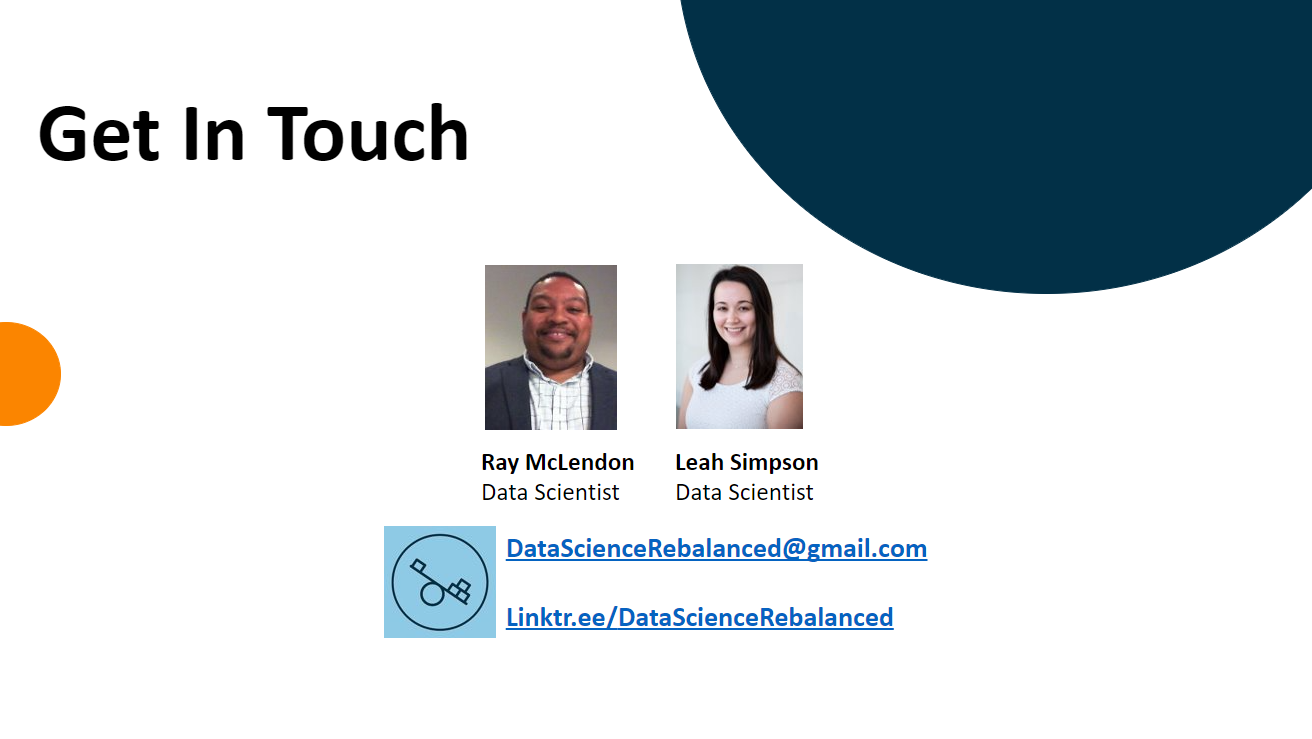